# Bank Customer Churn Prediction

Having a reliable model that accurately predicts whether a customer will churn or not can be a valuable resource for companies. By identifying which customers are likely to leave, companies can focus their efforts on retaining those customers, thereby improving overall customer retention. In this project, we use supervised learning models to identify customers who are likely to churn in the future. Furthermore, we will analyze top factors that influence user retention. [Dataset information](https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers).

This dataset contains details of a bank's customers and the target variable is a binary variable reflecting the fact whether the customers left the bank (closed their account) or they continued to be a customer. It consists of 10,000 records with demographic and bank history information from customers from three countries, such as France, Germany and Spain.

The churn variable has imbalanced data. So, the solutions we used to handle imbalanced data are :

* Use K-fold Cross-Validation in the Right Way
* Resample Training set by SMOTE technique

# Contents

* Part 0: Import Data
* Part 1: Data Exploration
  * Part 1.1: Understand the Raw Dataset
  * Part 1.2: Understand the features
* Part 2: Feature Preprocessing
  * Part 2.1: Split dataset
  * Part 2.2: Standardize/Normalize Data
* Part 3: Model Training and Results Evaluation
  * Part 3.1: Model Training
  * Part 3.2: Use Grid Search to Find Optimal Hyperparameters
  * Part 3.3: Model Evaluation - Confusion Matrix
  * Part 3.4: Model Fine-tuning
  * Part 3.5: Build model pipelines with SMOTE
  * Part 3.6: Model Evaluation - ROC & AUC
* Part 4: Impact of SMOTE technique to model results
* Part 5: Model Extra Functionality

# Part 0: Setup Google Drive Environment / Data Collection
check this [link](https://colab.research.google.com/notebooks/io.ipynb) for more info

In [ ]:
# install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# https://drive.google.com/file/d/id/view?usp=sharing
id = ""
file = drive.CreateFile({'id':id})
file.GetContentFile('bank_churn.csv')

In [ ]:
# import package
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer, precision_recall_fscore_support

from sklearn.metrics import roc_curve
from sklearn import metrics

# Part 1: Data Exploration

### Part 1.1: Understand the Raw Dataset

In [ ]:
churn_df = pd.read_csv('bank_churn.csv')
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
print(f'dataset dimension: {churn_df.shape}')

dataset dimension: (10000, 14)


The dataframe has 1000 rows with 14 attributes.

In [ ]:
# check data info
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
# check the unique values for each column
churn_df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [ ]:
churn_df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [ ]:
print(f'dataset dimension: {churn_df.shape}')

dataset dimension: (10000, 11)


### Part 1.2:  Understand the features

In [ ]:
# check missing values
churn_df.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [ ]:
# understand Numerical feature
# discrete/continuous
# 'CreditScore', 'Age', 'Tenure', 'NumberOfProducts', 'Balance', 'EstimatedSalary'
churn_df[['CreditScore', 'Age', 'Tenure', 'NumOfProducts','Balance', 'EstimatedSalary']].describe()

,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,1.530200,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,0.581654,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,1.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,1.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,1.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,2.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,4.000000,250898.090000,199992.480000


In [ ]:
churn_df.groupby('Geography').mean()

<ipython-input-12-68ef1e9e931d>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  churn_df.groupby('Geography').mean()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Geography,,,,,,,,,
France,649.668329,38.511767,5.004587,62092.636516,1.530913,0.706621,0.516753,99899.180814,0.161548
Germany,651.453567,39.771622,5.009964,119730.116134,1.519729,0.713830,0.497409,101113.435102,0.324432
Spain,651.333872,38.890997,5.032297,61818.147763,1.539362,0.694792,0.529673,99440.572281,0.166734


In [ ]:
# check the feature distribution
# pandas.DataFrame.describe()
# boxplot, distplot, countplot

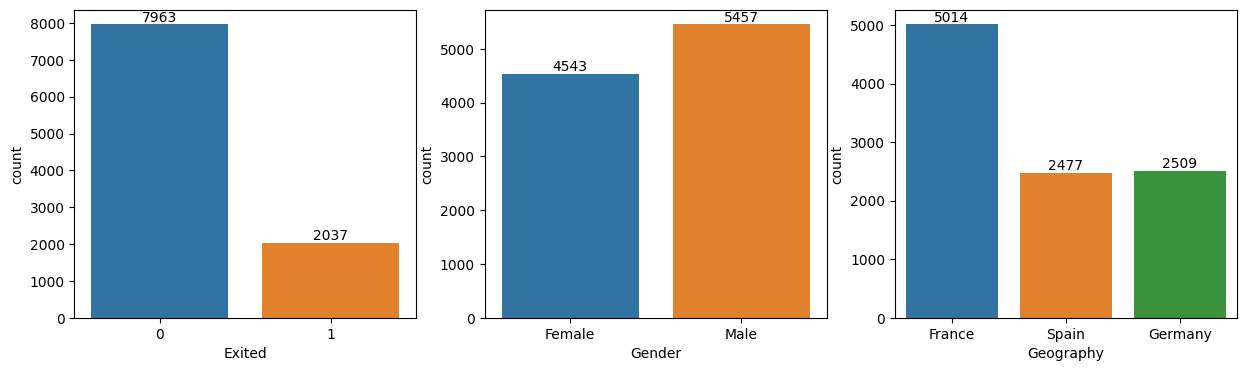

In [ ]:
# plt.figure(figsize=[4,4])
f, axes = plt.subplots(1, 3, figsize = [15,4])
sns.countplot(x='Exited', data=churn_df, order=[0, 1], label='Count', ax=axes[0])
axes[0].bar_label(axes[0].containers[0])
sns.countplot(x='Gender', data=churn_df, label='Count', ax=axes[1])
axes[1].bar_label(axes[1].containers[0])
sns.countplot(x='Geography', data=churn_df, label='Count', ax=axes[2])
axes[2].bar_label(axes[2].containers[0])
plt.show()

In the dataset, 80% customers do not churn, and only 20 percent of the customers left the bank. That indicates the dataset is imbalanced. More males than females. Majority of customers are from France, around 50%, and from Germany and Spain around 25% each.

<Axes: xlabel='Exited', ylabel='EstimatedSalary'>

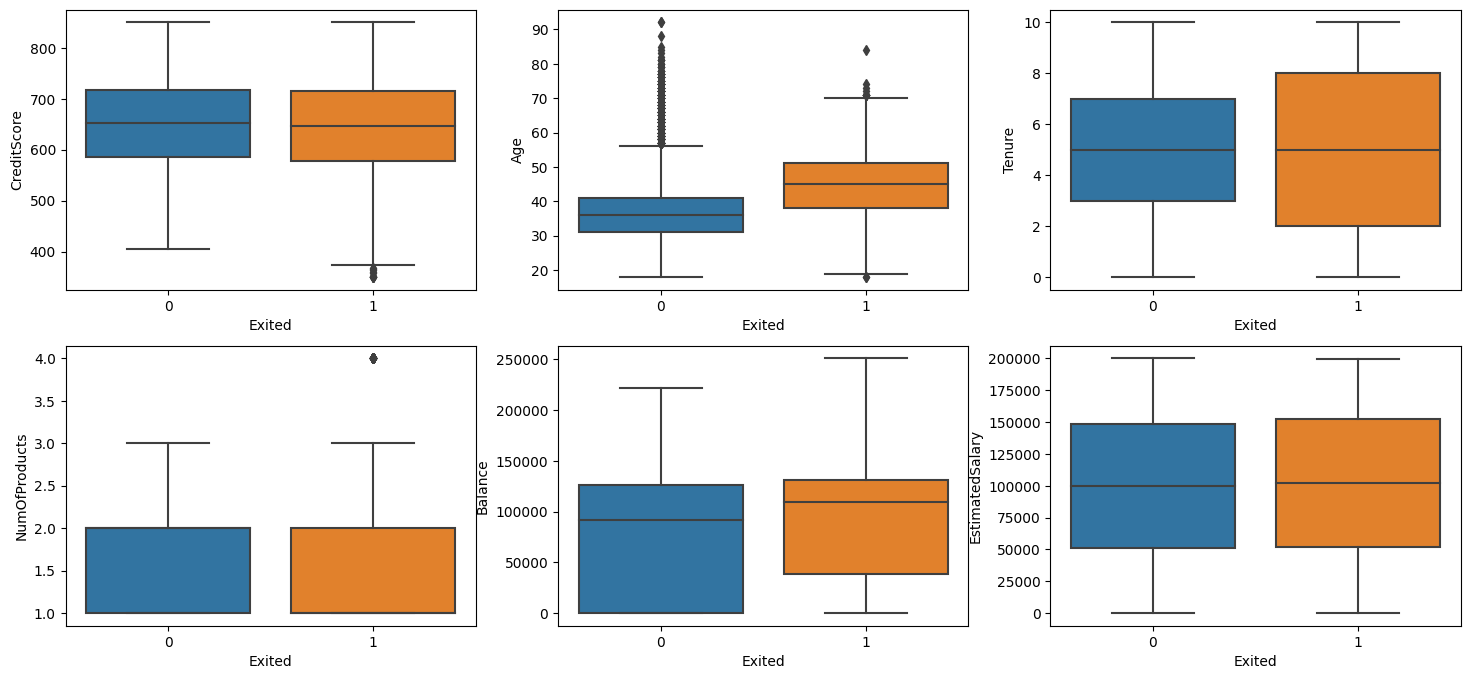

In [ ]:
# boxplot for numerical feature
_,axes = plt.subplots(2,3, figsize=[18,8])
sns.boxplot(x='Exited', y ='CreditScore', data=churn_df, ax=axes[0][0])
sns.boxplot(x='Exited', y ='Age', data=churn_df, ax=axes[0][1])
sns.boxplot(x='Exited', y ='Tenure', data=churn_df, ax=axes[0][2])
sns.boxplot(x='Exited', y ='NumOfProducts', data=churn_df, ax=axes[1][0])
sns.boxplot(x='Exited', y ='Balance', data=churn_df, ax=axes[1][1])
sns.boxplot(x='Exited', y ='EstimatedSalary', data=churn_df, ax=axes[1][2])


As we can see from boxplots above
* There is no significant difference between credit scores and churned customers.
* The elder churn easily than the younger. The bank may design different strategies for retention based on age groups.
* Custormers who spent lots of time or little time on the bank may churn compared with those with average tenure.
* The bank may lose customers who have high balance.
* Neither number of products nor salary has an effect on the churn rate.



In [ ]:
churn_df.columns


Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

<ipython-input-17-9307c89b9bd5>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_score = churn_df.corr()


<Axes: >

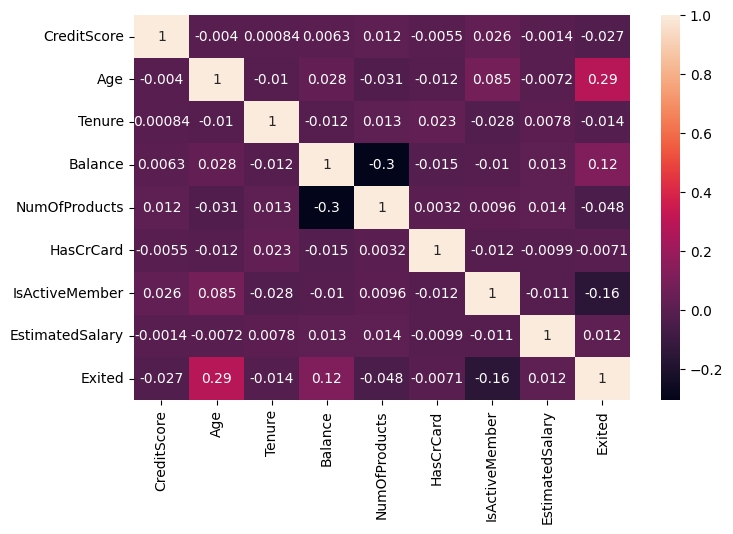

In [ ]:
# correlations between features
corr_score = churn_df.corr()
# show heapmap of correlations
plt.figure(figsize=(8,5))
sns.heatmap(corr_score,annot = True)

In [ ]:
# check the actual values of correlations in order with "Exited"
sort_corr_cols = corr_score.Exited.sort_values(ascending=False).keys()
sort_corr = corr_score.loc[sort_corr_cols,sort_corr_cols]
sort_corr

,Exited,Age,Balance,EstimatedSalary,HasCrCard,Tenure,CreditScore,NumOfProducts,IsActiveMember
Exited,1.000000,0.285323,0.118533,0.012097,-0.007138,-0.014001,-0.027094,-0.047820,-0.156128
Age,0.285323,1.000000,0.028308,-0.007201,-0.011721,-0.009997,-0.003965,-0.030680,0.085472
Balance,0.118533,0.028308,1.000000,0.012797,-0.014858,-0.012254,0.006268,-0.304180,-0.010084
EstimatedSalary,0.012097,-0.007201,0.012797,1.000000,-0.009933,0.007784,-0.001384,0.014204,-0.011421
HasCrCard,-0.007138,-0.011721,-0.014858,-0.009933,1.000000,0.022583,-0.005458,0.003183,-0.011866
Tenure,-0.014001,-0.009997,-0.012254,0.007784,0.022583,1.000000,0.000842,0.013444,-0.028362
CreditScore,-0.027094,-0.003965,0.006268,-0.001384,-0.005458,0.000842,1.000000,0.012238,0.025651
NumOfProducts,-0.047820,-0.030680,-0.304180,0.014204,0.003183,0.013444,0.012238,1.000000,0.009612
IsActiveMember,-0.156128,0.085472,-0.010084,-0.011421,-0.011866,-0.028362,0.025651,0.009612,1.000000


The relationships between churning and other factors are generally weak correlations. There is only a weak positive correlation with age, a very weak positive correlation with balance.

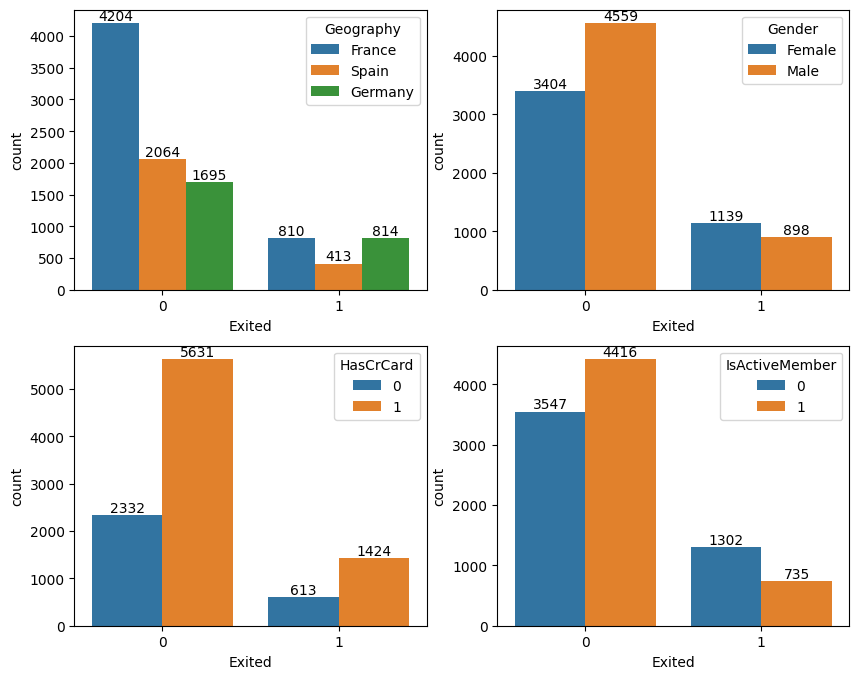

In [ ]:
_,axes = plt.subplots(2,2, figsize=[10,8])
sns.countplot(x='Exited', hue='Geography', data=churn_df, ax=axes[0][0])
sns.countplot(x='Exited', hue='Gender', data=churn_df, ax=axes[0][1])
sns.countplot(x='Exited', hue='HasCrCard', data=churn_df, ax=axes[1][0])
sns.countplot(x='Exited', hue='IsActiveMember', data=churn_df, ax=axes[1][1])
for i in [0,1]:
  for j in [0,1]:
    for container in axes[i][j].containers:
      axes[i][j].bar_label(container)

In [ ]:
data1 = churn_df.groupby(['Exited']).Gender.apply(lambda x:x.value_counts()/x.count()).reset_index()
data1.columns = ['Exited', 'Gender', 'Percentages']
data1

,Exited,Gender,Percentages
0,0,Male,0.572523
1,0,Female,0.427477
2,1,Female,0.559156
3,1,Male,0.440844


In [ ]:
def with_hue(ax, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in ax.patches]
    patch = [p for p in ax.patches]
    for i in range(Number_of_categories):
        total = feature.count().values[i]
        for j in range(hue_categories):
            percentage = '{:.2f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height()
            ax.annotate(percentage, (x, y), ha='center')

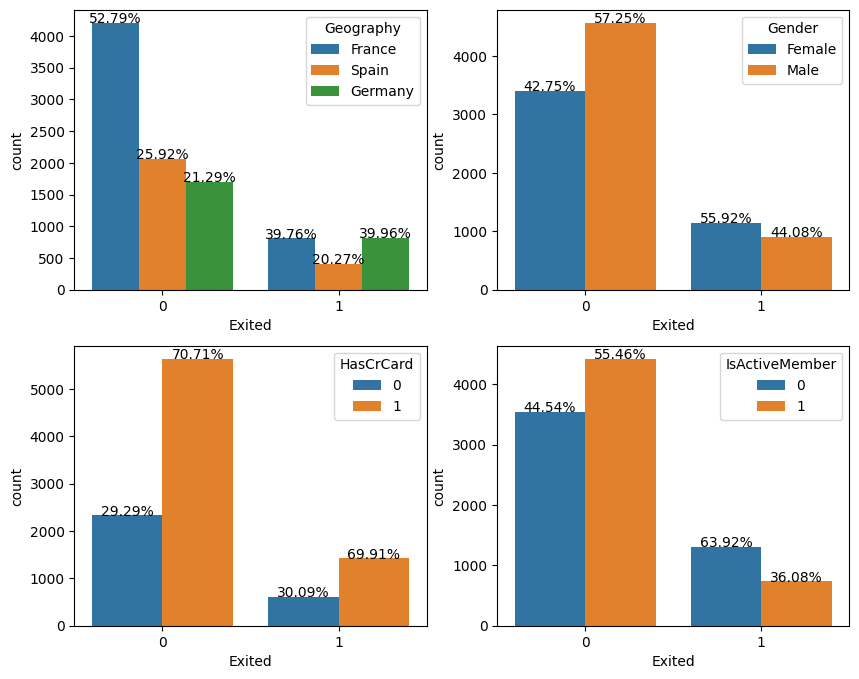

In [ ]:
# understand categorical feature with corresponding percentages
_,axes = plt.subplots(2,2, figsize=[10,8])
sns.countplot(x='Exited', hue='Geography', data=churn_df, ax=axes[0][0])
sns.countplot(x='Exited', hue='Gender', data=churn_df, ax=axes[0][1])
sns.countplot(x='Exited', hue='HasCrCard', data=churn_df, ax=axes[1][0])
sns.countplot(x='Exited', hue='IsActiveMember', data=churn_df, ax=axes[1][1])

with_hue(axes[0][0], churn_df.groupby(['Exited']).Geography, 2, 3)
with_hue(axes[0][1], churn_df.groupby(['Exited']).Gender, 2, 2)
with_hue(axes[1][0], churn_df.groupby(['Exited']).HasCrCard, 2, 2)
with_hue(axes[1][1], churn_df.groupby(['Exited']).IsActiveMember, 2, 2)
plt.show()

From histgrams above, we can know:
* The clients in the database is mainly from France. The bank is losing more clients from Germany (around 40%) that the other two countries.
* Female clients tend to churn easily than male clients.
* Customers who has credit cards leave the bank.
* It is not surprisingly that inactive clients have a higher churn rate. The bank may focus on a method that let customers become active.

# Part 2: Feature Preprocessing

In [ ]:
# Get feature space by dropping useless feature
X = churn_df.drop(['Exited'], axis=1)
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10


In [ ]:
X.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
dtype: object

In [ ]:
cat_cols = X.columns[X.dtypes == 'object']
num_cols = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')]

In [ ]:
cat_cols

Index(['Geography', 'Gender'], dtype='object')

In [ ]:
catagorical = [i for i in X.columns if X[i].dtypes == 'object']

for i in catagorical:
    print(i, ':', X[i].unique())

Geography : ['France' 'Spain' 'Germany']
Gender : ['Female' 'Male']


In [ ]:
num_cols

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary'],
      dtype='object')

In [ ]:
# Get target variable
y = churn_df['Exited']
y

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: Exited, Length: 10000, dtype: int64

### Part 2.1: Split dataset

**Normal case:**
* 10000 -> 8000 '0' + 2000 '1'

* 25% test 75% training
---
**extreme case:**

without stratified sampling:
1. testing: 2000 '1' + 500 '0'
2. training: 7500 '0'


with stratified sampling:
1. testing: 2000 '0' + 500 '1'
2. training: 6000 '0' + 1500 '1'


In [ ]:
# Splite data into training and testing

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, stratify = y, random_state=1) #stratified sampling
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7500, 10), (2500, 10), (7500,), (2500,))

In [ ]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7971,633,Spain,Male,42,10,0.00,1,0,1,79408.17
9152,708,Germany,Female,23,4,71433.08,1,1,0,103697.57
6732,548,France,Female,37,9,0.00,2,0,0,98029.58
902,645,France,Female,48,7,90612.34,1,1,1,149139.13
2996,729,Spain,Female,45,7,91091.06,2,1,0,71133.12


In [ ]:
# One hot encoding
# another way: get_dummies
# dataset = pd.get_dummies(data=dataset, drop_first=True)

def OneHotEncoding(df, enc, categories):
  transformed = pd.DataFrame(enc.transform(df[categories]).toarray(), columns = enc.get_feature_names_out(categories))
  return pd.concat([df.reset_index(drop=True), transformed], axis=1).drop(categories, axis=1)


In [ ]:
categories = ['Geography']
enc_cat = OneHotEncoder()
enc_cat.fit(X_train[categories])

X_train = OneHotEncoding(X_train, enc_cat, categories)
X_test = OneHotEncoding(X_test, enc_cat, categories)

X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,633,Male,42,10,0.00,1,0,1,79408.17,0.0,0.0,1.0
1,708,Female,23,4,71433.08,1,1,0,103697.57,0.0,1.0,0.0
2,548,Female,37,9,0.00,2,0,0,98029.58,1.0,0.0,0.0
3,645,Female,48,7,90612.34,1,1,1,149139.13,1.0,0.0,0.0
4,729,Female,45,7,91091.06,2,1,0,71133.12,0.0,0.0,1.0


In [ ]:
# Ordinal encoding

categories = ['Gender']
enc_ord = OrdinalEncoder()
enc_ord.fit(X_train[categories])

X_train[categories] = enc_ord.transform(X_train[categories])
X_test[categories] = enc_ord.transform(X_test[categories])
X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,633,1.0,42,10,0.00,1,0,1,79408.17,0.0,0.0,1.0
1,708,0.0,23,4,71433.08,1,1,0,103697.57,0.0,1.0,0.0
2,548,0.0,37,9,0.00,2,0,0,98029.58,1.0,0.0,0.0
3,645,0.0,48,7,90612.34,1,1,1,149139.13,1.0,0.0,0.0
4,729,0.0,45,7,91091.06,2,1,0,71133.12,0.0,0.0,1.0


### Part 2.2: Standardize/Normalize Data

In [ ]:
# Scale the data, using standardization
# standardization (x-mean)/std
# normalization (x-x_min)/(x_max-x_min) ->[0,1]

scaler = StandardScaler()
scaler.fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

X_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,-0.172985,1.0,0.289202,1.731199,-1.218916,-0.912769,-1.542199,0.968496,-0.352044,0.0,0.0,1.0
1,0.602407,0.0,-1.509319,-0.341156,-0.076977,-0.912769,0.648425,-1.032529,0.072315,0.0,1.0,0.0
2,-1.051762,0.0,-0.184093,1.385806,-1.218916,0.796109,-1.542199,-1.032529,-0.026711,1.0,0.0,0.0
3,-0.048922,0.0,0.857156,0.695022,0.229625,-0.912769,0.648425,0.968496,0.866221,1.0,0.0,0.0
4,0.819517,0.0,0.573179,0.695022,0.237278,0.796109,0.648425,-1.032529,-0.496617,0.0,0.0,1.0


# Part 3: Model Training and Result Evaluation

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

### Part 3.1: Model Training

Build models: since our target variable has imbalanced dataset, we will not use the accuracy score. The recall is used in an imbalanced class problem with two classes, which quantifies the number of correct predictions of positive made out of all positive predictions. Precision is another choice of metric which calculates accuracy for the minority class.

In [ ]:
# Use 5-fold Cross Validation to get the accuracy for different models

def generate_results(classifiers, model_names):
  count = 0
  for classifier in classifiers:
  # for classifier in model_list:
      # classifier.fit(X_train, y_train)
      # classifier.predict(X_test)
      # classifier.score(X_test, y_test)

      # Define the scoring metric
      scoring = {'accuracy' : make_scorer(accuracy_score),
                'precision' : make_scorer(precision_score),
                'recall' : make_scorer(recall_score),
                'f1_score' : make_scorer(f1_score)}
      cv_score = model_selection.cross_validate(classifier, X_train, y_train, cv=5, scoring=scoring)

      acc = cv_score['test_accuracy'].mean()
      f1 = cv_score['test_f1_score'].mean()
      prec = cv_score['test_precision'].mean()
      rec = cv_score['test_recall'].mean()
      results = pd.DataFrame([[model_names[count], acc, f1, prec, rec]],
                        columns = ["Model", "accuracy", "f1", "precision", "recall"])


      if count > 0:
        model_results = pd.concat([model_results, results], ignore_index=True)
      else:
        model_results = results
      count += 1
  return model_results

In [ ]:
classifiers = [
    KNeighborsClassifier(),
    LogisticRegression(),
    RandomForestClassifier(),
    XGBClassifier()
    ]
model_names = ['KNN','Logistic Regression','Random Forest', 'XGBoost']
generate_results(classifiers, model_names)

,Model,accuracy,f1,precision,recall
0,KNN,0.836533,0.509116,0.656159,0.416233
1,Logistic Regression,0.812400,0.322028,0.613425,0.218579
2,Random Forest,0.862400,0.586228,0.757204,0.478412
3,XGBoost,0.852267,0.578898,0.690580,0.498701


### Part 3.2: Use Grid Search to Find Optimal Hyperparameters
alternative: random search

In [ ]:
#Loss/cost function --> (wx + b - y) ^2 + ƛ * |w| --> ƛ is a hyperparameter

In [ ]:
# helper function for printing out grid search results
def print_grid_search_metrics(grid_model):
    print ("Best score: " + str(grid_model.best_score_))
    print ("Best parameters set:")
    best_parameters = grid_model.best_params_ # {'C': 10, 'fit_intercept': True,...}
    for param_name in sorted(best_parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

#### Part 3.2.1: Find Optimal Hyperparameters: KNN

In [ ]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[1,3,5,7,9]
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5)
Grid_KNN.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 3, 5, 7, 9]})

In [ ]:
# best k
print_grid_search_metrics(Grid_KNN)
best_KNN_model = Grid_KNN.best_estimator_
best_KNN_model

Best score: 0.8433333333333334
Best parameters set:
n_neighbors:9


KNeighborsClassifier(n_neighbors=9)

#### Part 3.2.2: Find Optimal Hyperparameters: LogisticRegression



In [ ]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the 1/lambda value(weight) for L1 and L2
# solver: algorithm to find the weights that minimize the cost function

parameters = {
    'penalty':('l1', 'l2'),
    'C':(0.01, 0.05, 0.1, 0.2, 1)
}
Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': (0.01, 0.05, 0.1, 0.2, 1),
                         'penalty': ('l1', 'l2')})

In [ ]:
# the best hyperparameter combination
# C = 1/lambda
print_grid_search_metrics(Grid_LR)
best_LR_model = Grid_LR.best_estimator_
best_LR_model

Best score: 0.8125333333333333
Best parameters set:
C:1
penalty:l1


LogisticRegression(C=1, penalty='l1', solver='liblinear')

#### Part 3.2.3: Find Optimal Hyperparameters: Random Forest

In [ ]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [40, 50, 60, 80],
    'max_depth': [3, 5, 8, 10]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5)
Grid_RF.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 5, 8, 10],
                         'n_estimators': [40, 50, 60, 80]})

In [ ]:
# best number of tree
print_grid_search_metrics(Grid_RF)
best_RF_model = Grid_RF.best_estimator_
best_RF_model

Best score: 0.8656
Best parameters set:
max_depth:10
n_estimators:80


RandomForestClassifier(max_depth=10, n_estimators=80)

#### Part 3.2.4: Find Optimal Hyperparameters: XGBoost

In [ ]:
param_grid = {'gamma': [0.5, 0.8, 1],
              'max_depth': [3, 4, 5, 6],
              'n_estimators': [50, 100, 200]
        }
Grid_XGB = GridSearchCV(XGBClassifier(),parameters, cv=5)
Grid_XGB.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'max_depth': [3, 5, 8, 10],
                         'n_estimators': [40, 50, 60, 80]})

In [ ]:
print_grid_search_metrics(Grid_XGB)
best_XGB_model = Grid_XGB.best_estimator_
best_XGB_model

Best score: 0.8682666666666666
Best parameters set:
max_depth:3
n_estimators:50


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

### Part 3.3: Model Evaluation - Confusion Matrix (Precision, Recall, Accuracy)

class of interest as positive

TP: correctly labeled real churn

Precision(PPV, positive predictive value): tp / (tp + fp);
Total number of true predictive churn divided by the total number of predictive churn;
High Precision means low fp, not many return users were predicted as churn users.


Recall(sensitivity, hit rate, true positive rate): tp / (tp + fn)
Predict most postive or churn user correctly. High recall means low fn, not many churn users were predicted as return users.

In [ ]:
classifiers = [best_KNN_model, best_LR_model, best_RF_model, best_XGB_model]
model_names = ['KNN','Logistic Regression','Random Forest','XGBoost']
generate_results(classifiers, model_names)

,Model,accuracy,f1,precision,recall
0,KNN,0.843333,0.502695,0.711556,0.388762
1,Logistic Regression,0.812533,0.321546,0.615525,0.217926
2,Random Forest,0.864800,0.577774,0.793536,0.454861
3,XGBoost,0.868267,0.606639,0.774696,0.498701


### Part 3.4: Tune the Hyperparameters of Classifiers

According to the models above, the models that has a decent balance of recall and precision are random forest and XGBoost. Based on the training set, with the precision score on 1 of 0.79, out of all customers, the model thought they will churn, 79% of them actually churn. With the recall score on 1 of 0.46, out of all churning customers, the model detects 46% of them will churn. XGBoost has a precision of 0.77 and recall of 0.50.

In [ ]:
def fine_tune_CV(pipeline, hyperparameters):

    model = GridSearchCV(pipeline, hyperparameters, cv=5)
    model.fit(X_train, y_train)
    print_grid_search_metrics(model)
    best_model = model.best_estimator_

    print('model has been fitted')
    return best_model

#### Part 3.4.1: Tune the Hyperparameters of Random Forest Classifier

In [ ]:
parameters = {
    'n_estimators': [70, 80, 90],
    'max_depth': [9, 11, 13],
}
pipeline = RandomForestClassifier()
best_RF_model = fine_tune_CV(pipeline, parameters)


Best score: 0.8664
Best parameters set:
max_depth:11
n_estimators:80
model has been fitted


#### Part 3.4.2: Tune the Hyperparameters of XGBoost Classifier

In [ ]:
parameters = {'gamma': [0.5, 0.8, 1],
              'max_depth': [1, 2, 3, 4],
              'n_estimators': [30, 40, 50, 60]
        }
pipeline = XGBClassifier()
best_XGB_model = fine_tune_CV(pipeline, parameters)

Best score: 0.8673333333333332
Best parameters set:
gamma:0.5
max_depth:3
n_estimators:60
model has been fitted


In [ ]:
classifiers = [best_RF_model, best_XGB_model]
model_names = ['Random Forest','XGBoost']
generate_results(classifiers, model_names)

,Model,accuracy,f1,precision,recall
0,Random Forest,0.867200,0.589208,0.796058,0.467952
1,XGBoost,0.867333,0.606395,0.766842,0.501963


### Part 3.5: Build model pipelines with SMOTE

In this notebook, we used Synthetic Minority Over-sampling Technique (SMOTE) to handle imbalanced data.

In [ ]:
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbl_pipe

In [ ]:
parameters = {
    'randomforestclassifier__n_estimators': [90],
    'randomforestclassifier__max_depth': [11],
}

pipeline = imbl_pipe(SMOTE(sampling_strategy='auto', random_state=1),
                  RandomForestClassifier())
best_RF_model_SMOTE = fine_tune_CV(pipeline, parameters)

Best score: 0.8422666666666666
Best parameters set:
randomforestclassifier__max_depth:11
randomforestclassifier__n_estimators:90
model has been fitted


In [ ]:
parameters = {'xgbclassifier__gamma': [0.5],
              'xgbclassifier__max_depth': [3],
              'xgbclassifier__n_estimators': [60]
        }
pipeline = imbl_pipe(SMOTE(sampling_strategy='auto', random_state=1),
                  XGBClassifier())
best_XGB_model_SMOTE = fine_tune_CV(pipeline, parameters)

Best score: 0.8555999999999999
Best parameters set:
xgbclassifier__gamma:0.5
xgbclassifier__max_depth:3
xgbclassifier__n_estimators:60
model has been fitted


In [ ]:
classifiers = [best_RF_model, best_XGB_model, best_RF_model_SMOTE, best_XGB_model_SMOTE]
model_names = ['Random Forest','XGBoost','Random Forest with SMOTE','XGBoost with SMOTE']
generate_results(classifiers, model_names)

,Model,accuracy,f1,precision,recall
0,Random Forest,0.865333,0.583406,0.789156,0.463364
1,XGBoost,0.867333,0.606395,0.766842,0.501963
2,Random Forest with SMOTE,0.842533,0.622411,0.608952,0.637437
3,XGBoost with SMOTE,0.855600,0.630663,0.658766,0.605355


It is evident that using SMOTE leads to significantly improved recall and F1 outcomes, which is a typical goal for customer churning tasks.

### Part 3.6: Model Evaluation - ROC & AUC

#### Part 3.6.1: Random Forest Model

In [ ]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

In [ ]:
best_RF_model.predict_proba(X_test) # shape:(2500, 2)

array([[0.72435026, 0.27564974],
       [0.93532952, 0.06467048],
       [0.66537753, 0.33462247],
       ...,
       [0.89778843, 0.10221157],
       [0.92958249, 0.07041751],
       [0.90246415, 0.09753585]])

#### Part 3.6.1: XGBoost Model

In [ ]:
# Use predict_proba to get the probability results of XGB
y_pred_xgb = best_XGB_model.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, thresh = roc_curve(y_test, y_pred_xgb)
best_XGB_model.predict_proba(X_test)

array([[0.72890997, 0.27109003],
       [0.9415348 , 0.05846516],
       [0.7208499 , 0.27915013],
       ...,
       [0.82209754, 0.17790246],
       [0.93076354, 0.06923646],
       [0.9415934 , 0.05840658]], dtype=float32)

# Part 4: Impact of SMOTE technique to model results

In [ ]:
# Use predict_proba to get the probability results of Random Forest with SMOTE
y_pred_rf_smote = best_RF_model_SMOTE.predict_proba(X_test)[:, 1]
fpr_rf_smote, tpr_rf_smote, _ = roc_curve(y_test, y_pred_rf_smote)
best_RF_model_SMOTE.predict_proba(X_test)

array([[0.47100742, 0.52899258],
       [0.90048137, 0.09951863],
       [0.47709759, 0.52290241],
       ...,
       [0.67392709, 0.32607291],
       [0.84868018, 0.15131982],
       [0.8797115 , 0.1202885 ]])

In [ ]:
# Use predict_proba to get the probability results of XGB
y_pred_xgb_smote = best_XGB_model_SMOTE.predict_proba(X_test)[:, 1]
fpr_xgb_smote, tpr_xgb_smote, thresh = roc_curve(y_test, y_pred_xgb_smote)
best_XGB_model_SMOTE.predict_proba(X_test)

array([[0.6424937 , 0.35750625],
       [0.80011123, 0.19988878],
       [0.4797895 , 0.5202105 ],
       ...,
       [0.67059505, 0.32940498],
       [0.90611356, 0.09388646],
       [0.92175645, 0.07824356]], dtype=float32)

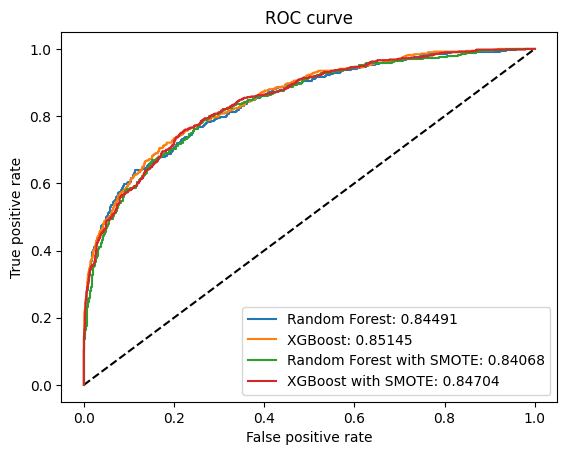

In [ ]:
# ROC curve
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='Random Forest: '+str(round(metrics.auc(fpr_rf,tpr_rf),5)))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost: '+str(round(metrics.auc(fpr_xgb,tpr_xgb),5)))
plt.plot(fpr_rf_smote, tpr_rf_smote, label='Random Forest with SMOTE: '+str(round(metrics.auc(fpr_rf_smote,tpr_rf_smote),5)))
plt.plot(fpr_xgb_smote, tpr_xgb_smote, label='XGBoost with SMOTE: '+str(round(metrics.auc(fpr_xgb_smote,tpr_xgb_smote),5)))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

XGBoost and Random Forest are the best algorithms to predict Bank Customer Churn since they have perfect AUC Scores, although there's slight difference between using SMOTE techniques and not.

In [ ]:
def plot_norm_conf_matrices(fit_models, models, color):
    # Prepare lists of coordinates for axes
    lt = []  # list for full subplots
    ltd = []  # list for empty subplots
    col = 2  # number of columns
    n_mod = len(fit_models)  # number of fitted models

    # Number of rows
    row = - (n_mod // -col)

    # Create lists of coordinates for full and empty subplots
    for r in range(row):
        for c in range(col):
            if n_mod >= (r + 1) * (c + 1):
                lt.append([r, c])
            else:
                ltd.append([r, c])

    # Create figure and subplots
    figs_y = row * 4  # y size
    f, axs = plt.subplots(row, col, figsize=(8, figs_y))
    f.suptitle('Normalized Confusion Matrices', fontsize=14)
    f.subplots_adjust(top=0.94, wspace=0.90, hspace=0.2)

    # Reshape axes; needed in case of only 1 row
    axs = axs.reshape(row,-col)

    # Loop to delete N last empty subplots (if any)
    for n in range(len(ltd)):
        r = ltd[n][0]
        c = ltd[n][1]
        f.delaxes(ax= axs[r, c])

    i = 0
    # Loop for each fitted model
    for id, model in fit_models.items():
        pred = model.predict(X_test)
        name = models[id]
        r = lt[i][0]
        c = lt[i][1]
        i += 1

        mat = confusion_matrix(y_test, pred)
        # normalized confusion matrix
        matn = mat / mat.sum(axis=1)[:, np.newaxis]

        ax = axs[r, c]
        sns.heatmap(matn,
                    annot=True,
                    annot_kws=dict(fontsize=14),
                    fmt='.2f',
                    cbar=False,
                    square=True,
                    cmap=color,
                    vmin = 0,
                    vmax = 1,
                    #cbar_kws = {'shrink' : 0.85},
                    ax=ax)

        target_names = ['Stays', 'Exits']
        ax.set_xticklabels(labels=target_names)
        ax.set_yticklabels(labels=target_names, va='center')
        ax.set_title(name)
        ax.set_xlabel('Predicted Label', size=12)
        ax.set_ylabel('True Label', size=12)

    plt.show()

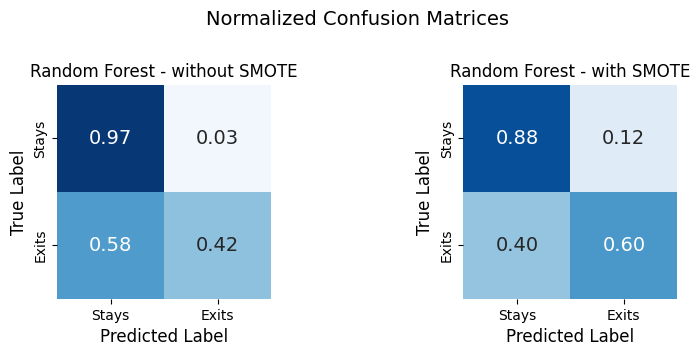

In [ ]:
models_rf = {
    'rf_whs' : 'Random Forest - without SMOTE',
    'rf_ws' : 'Random Forest - with SMOTE'
}
loaded_models_rf = {
    'rf_whs' : best_RF_model,
    'rf_ws' : best_RF_model_SMOTE
}
plot_norm_conf_matrices(loaded_models_rf, models_rf, 'Blues')

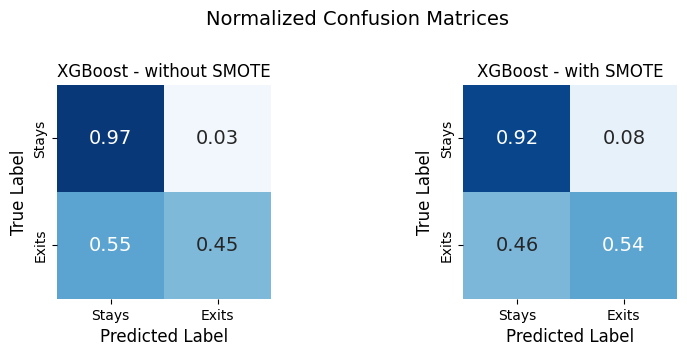

In [ ]:
models_xgb = {
    'xgb_whs' : 'XGBoost - without SMOTE',
    'xgb_ws' : 'XGBoost - with SMOTE'
}
loaded_models_xgb = {
    'xgb_whs' : best_XGB_model,
    'xgb_ws' : best_XGB_model_SMOTE
}
plot_norm_conf_matrices(loaded_models_xgb, models_xgb, 'Blues')

As we can see from the plots above, using SMOTE has improved true postive rates (customer churning rate) for Random Forest (42%->60%) and for XGBoost (45%->54%). We can observe an increase in non-fraud cases being classified as fraud (false positives) on both models. The reason this happens is that SMOTE has oversampled the fraud class so much that it has increased its overlap in the feature space with the non-fraud cases.

# Part 5: Model Extra Functionality

#### Part 5.1:  Logistic Regression Model

The corelated features that we are interested in

In [ ]:
X_with_corr = X.copy()

X_with_corr = OneHotEncoding(X_with_corr, enc_cat, ['Geography'])
X_with_corr['Gender'] = enc_ord.transform(X_with_corr[['Gender']])
X_with_corr['SalaryInRMB'] = X_with_corr['EstimatedSalary'] * 6.8 # add a new column
X_with_corr.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,SalaryInRMB
0,619,0.0,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0,689172.384
1,608,0.0,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0,765289.544
2,502,0.0,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0,774734.676
3,699,0.0,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0,638021.084
4,850,0.0,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0,537771.880


In [ ]:
# add L1 regularization to logistic regression
# check the coef for feature selection
scaler = StandardScaler()
X_l1 = scaler.fit_transform(X_with_corr)
LRmodel_l1 = LogisticRegression(penalty="l1", C = 0.04, solver='liblinear')
LRmodel_l1.fit(X_l1, y)

indices = np.argsort(abs(LRmodel_l1.coef_[0]))[::-1]

print ("Logistic Regression (L1) Coefficients")
for ind in range(X_with_corr.shape[1]):
  print ("{0} : {1}".format(X_with_corr.columns[indices[ind]],round(LRmodel_l1.coef_[0][indices[ind]], 4)))

Logistic Regression (L1) Coefficients
Age : 0.7307
IsActiveMember : -0.5046
Geography_Germany : 0.3121
Gender : -0.2409
Balance : 0.1509
CreditScore : -0.0457
NumOfProducts : -0.0439
Tenure : -0.0271
SalaryInRMB : 0.0092
Geography_France : -0.0043
HasCrCard : -0.0022
EstimatedSalary : 0.0
Geography_Spain : 0.0


In [ ]:
# add L2 regularization to logistic regression
# check the coef for feature selection
np.random.seed()
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X_with_corr)
LRmodel_l2 = LogisticRegression(penalty="l2", C = 0.1, solver='liblinear', random_state=42)
LRmodel_l2.fit(X_l2, y)
LRmodel_l2.coef_[0]

indices = np.argsort(abs(LRmodel_l2.coef_[0]))[::-1]

print ("Logistic Regression (L2) Coefficients")
for ind in range(X_with_corr.shape[1]):
  print ("{0} : {1}".format(X_with_corr.columns[indices[ind]],round(LRmodel_l2.coef_[0][indices[ind]], 4)))

Logistic Regression (L2) Coefficients
Age : 0.751
IsActiveMember : -0.5272
Gender : -0.2591
Geography_Germany : 0.2279
Balance : 0.162
Geography_France : -0.1207
Geography_Spain : -0.089
CreditScore : -0.0637
NumOfProducts : -0.0586
Tenure : -0.0452
HasCrCard : -0.0199
EstimatedSalary : 0.0137
SalaryInRMB : 0.0137


L1 regularization penalizes the sum of absolute values of the weights, whereas L2 regularization penalizes the sum of squares of the weights. L1 regularization gives multiple solutions and constructed in feature selection. L2 regularization is stable and has only one solution. L2 regularization cannot perform feature selection, since weights are only reduced to values near 0 instead of 0.

#### Part 5.2:  Random Forest Model - Feature Importance Discussion

In [ ]:
X_RF = X.copy()

X_RF = OneHotEncoding(X_RF, enc_cat, ['Geography'])
X_RF['Gender'] = enc_ord.transform(X_RF[['Gender']])

X_RF.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,0.0,42,2,0.00,1,1,1,101348.88,1.0,0.0,0.0
1,608,0.0,41,1,83807.86,1,0,1,112542.58,0.0,0.0,1.0
2,502,0.0,42,8,159660.80,3,1,0,113931.57,1.0,0.0,0.0
3,699,0.0,39,1,0.00,2,0,0,93826.63,1.0,0.0,0.0
4,850,0.0,43,2,125510.82,1,1,1,79084.10,0.0,0.0,1.0


In [ ]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X_RF, y)

importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(X.shape[1]):
  print ("{0} : {1}".format(X_RF.columns[indices[ind]],round(importances[indices[ind]], 4)))

Feature importance ranking by Random Forest Model:
Age : 0.2403
EstimatedSalary : 0.1461
CreditScore : 0.1432
Balance : 0.1422
NumOfProducts : 0.1294
Tenure : 0.0827
IsActiveMember : 0.0408
Geography_Germany : 0.0206
Gender : 0.0183
HasCrCard : 0.0181
